In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1225,  313]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


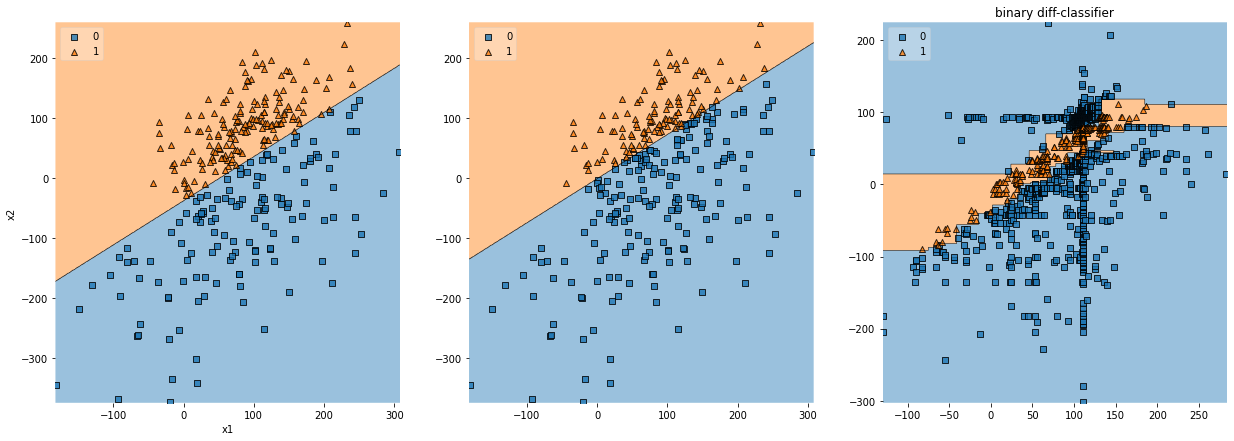

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(702.8125, 871.1538461538462, 'x2 <= 80.5\ngini = 0.324\nsamples = 1538\nvalue = [1225, 313]\nclass = no_diff'),
 Text(565.625, 801.4615384615385, 'x2 <= 46.5\ngini = 0.43\nsamples = 892\nvalue = [613, 279]\nclass = no_diff'),
 Text(386.25, 731.7692307692307, 'x1 <= 77.0\ngini = 0.264\nsamples = 683\nvalue = [576, 107]\nclass = no_diff'),
 Text(252.5, 662.0769230769231, 'x2 <= 0.5\ngini = 0.459\nsamples = 280\nvalue = [180, 100]\nclass = no_diff'),
 Text(150.0, 592.3846153846154, 'x1 <= 20.5\ngini = 0.251\nsamples = 204\nvalue = [174, 30]\nclass = no_diff'),
 Text(110.0, 522.6923076923076, 'x2 <= -28.0\ngini = 0.423\nsamples = 92\nvalue = [64, 28]\nclass = no_diff'),
 Text(90.0, 453.0, 'x2 <= -90.5\ngini = 0.308\nsamples = 79\nvalue = [64, 15]\nclass = no_diff'),
 Text(70.0, 383.30769230769226, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]\nclass = no_diff'),
 Text(110.0, 383.30769230769226, 'x1 <= -40.5\ngini = 0.415\nsamples = 51\nvalue = [36, 15]\nclass = no_diff'),
 Text(60.0, 31

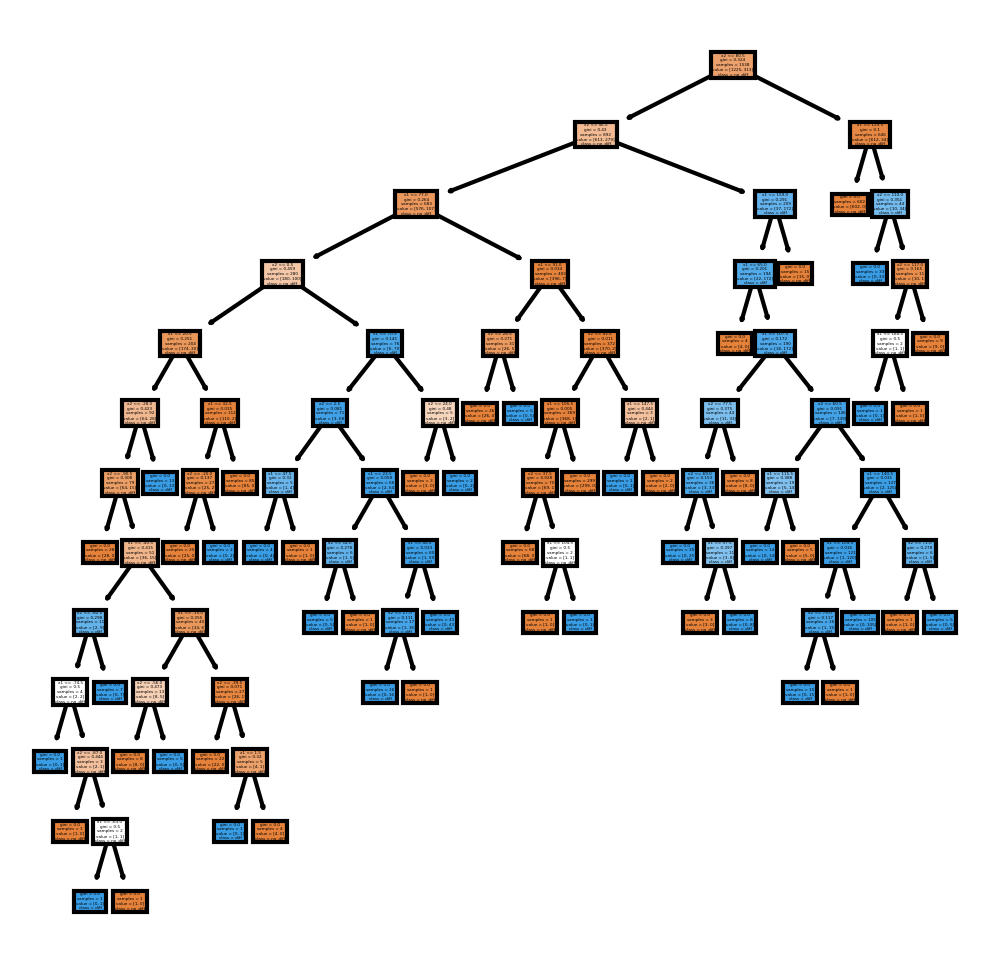

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_2 <= 80.5, feature_2 <= 46.5, feature_1 <= 77.0, feature_2 <= 0.5, feature_1 <= 20.5, feature_2 <= -28.0, feature_2 > -90.5, feature_1 <= -40.5, feature_2 <= -82.0, feature_1 <= -74.5}'}
{'diff': '{feature_2 <= 80.5, feature_2 <= 46.5, feature_1 <= 77.0, feature_2 <= 0.5, feature_1 <= 20.5, feature_2 <= -28.0, feature_2 > -90.5, feature_1 <= -40.5, feature_2 <= -82.0, feature_1 > -74.5, feature_2 > -87.0, feature_1 <= -63.0}'}
{'diff': '{feature_2 <= 80.5, feature_2 <= 46.5, feature_1 <= 77.0, feature_2 <= 0.5, feature_1 <= 20.5, feature_2 <= -28.0, feature_2 > -90.5, feature_1 <= -40.5, feature_2 > -82.0}'}
{'diff': '{feature_2 <= 80.5, feature_2 <= 46.5, feature_1 <= 77.0, feature_2 <= 0.5, feature_1 <= 20.5, feature_2 <= -28.0, feature_2 > -90.5, feature_1 > -40.5, feature_1 <= -15.0, feature_2 > -56.0}'}
{'diff': '{feature_2 <= 80.5, feature_2 <= 46.5, feature_1 <= 77.0, feature_2 <= 0.5, feature_1 <= 20.5, feature_2 <= -28.0, feature_2 > -90.5, feature_1 > -40.5

## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 3]), array([803, 631, 393]))


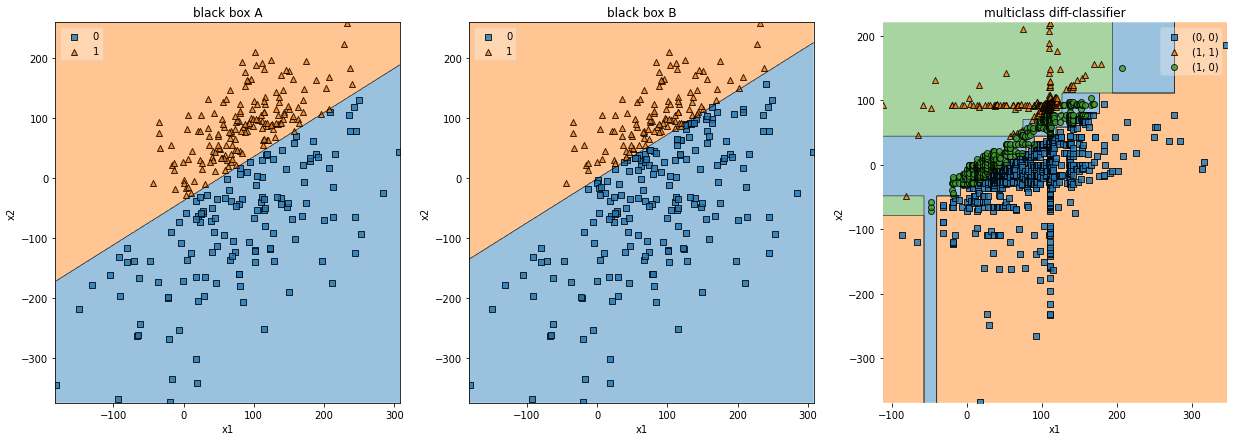

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(646.3715277777777, 860.7, 'x2 <= 79.5\ngini = 0.641\nsamples = 1827\nvalue = [803, 631, 393]\nclass = (0, 0)'),
 Text(466.07638888888886, 770.1, 'x2 <= 44.5\ngini = 0.441\nsamples = 1175\nvalue = [801, 14, 360]\nclass = (0, 0)'),
 Text(264.79166666666663, 679.5, 'x1 <= 35.5\ngini = 0.342\nsamples = 988\nvalue = [772, 1, 215]\nclass = (0, 0)'),
 Text(172.22222222222223, 588.9000000000001, 'x2 <= -23.5\ngini = 0.462\nsamples = 263\nvalue = [93, 1, 169]\nclass = (1, 0)'),
 Text(120.55555555555554, 498.3, 'x1 <= 9.5\ngini = 0.346\nsamples = 105\nvalue = [82, 1, 22]\nclass = (0, 0)'),
 Text(103.33333333333333, 407.70000000000005, 'x2 <= -47.5\ngini = 0.516\nsamples = 49\nvalue = [26, 1, 22]\nclass = (0, 0)'),
 Text(68.88888888888889, 317.1, 'x1 <= -39.5\ngini = 0.253\nsamples = 28\nvalue = [24, 1, 3]\nclass = (0, 0)'),
 Text(51.666666666666664, 226.5, 'x1 <= -56.5\ngini = 0.611\nsamples = 6\nvalue = [2, 1, 3]\nclass = (1, 0)'),
 Text(34.44444444444444, 135.9000000000001, 'x2 <= -78.5\

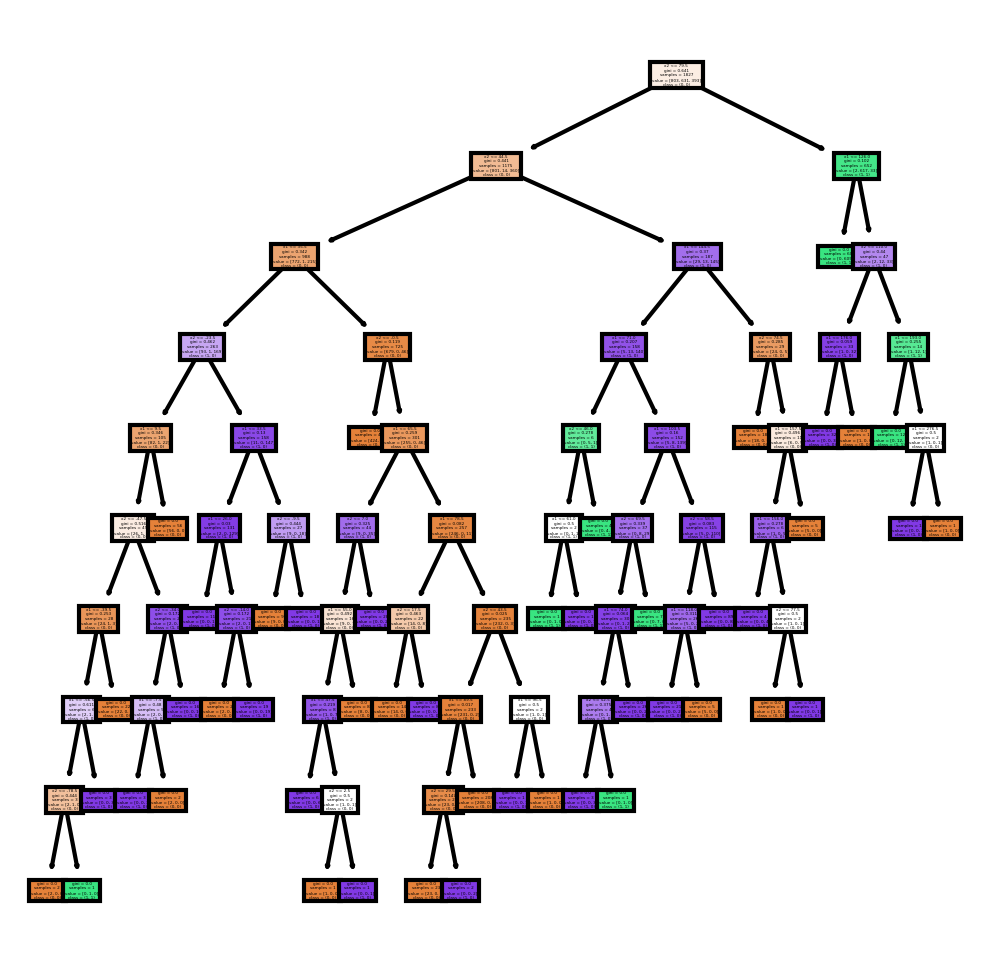

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)